In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../Data/Alcohol_Sales.csv',index_col='DATE',parse_dates=True)

In [3]:
df.index.freq = 'MS'

In [4]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [5]:
df.columns = ['Sales']

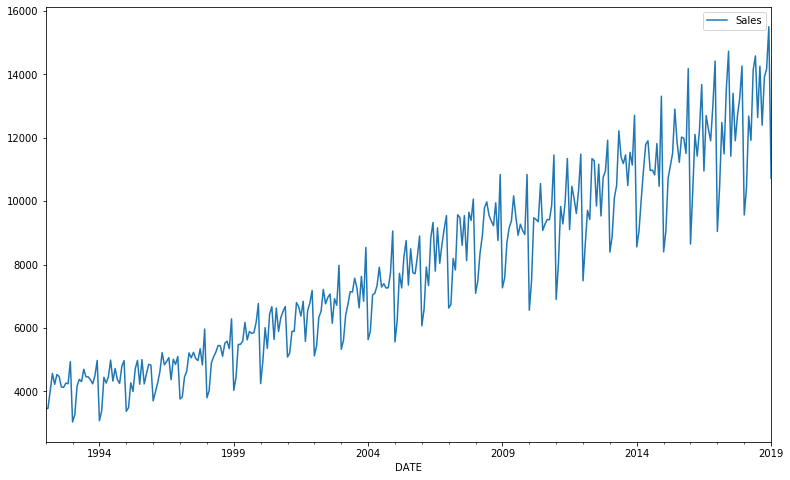

In [6]:
df.plot(figsize=(13,8))

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
results = seasonal_decompose(df['Sales'])

/home/tim/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


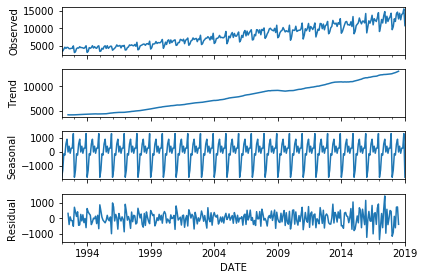

In [9]:
results.plot();

In [10]:
len(df)

325

In [11]:
train = df.iloc[:313]
test = df.iloc[313:]

In [12]:
len(test)

12

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [16]:
scaled = scaler.transform(train)

In [17]:
scaled_test = scaler.transform(test)
scaled_train = scaler.transform(train)

In [18]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [31]:
n_input = 12
n_features = 1
train_gen = TimeseriesGenerator(scaled_train,scaled_train,length = n_input,batch_size=1)

In [20]:
len(scaled_train)

313

In [21]:
len(gen)

311

In [22]:
gen[0]

(array([[[0.03658432],
         [0.03649885]]]), array([[0.08299855]]))

In [23]:
x,y = gen[0]

In [24]:
x

array([[[0.03658432],
        [0.03649885]]])

In [25]:
y

array([[0.08299855]])

In [26]:
from keras.models import Sequential

In [27]:
from keras.layers import Dense,LSTM

In [29]:
model = Sequential()

model.add(LSTM(150,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

Instructions for updating:
Colocations handled automatically by placer.


In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit_generator(train_gen,epochs=25)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
301/301 [==============================] - 6s 22ms/step - loss: 0.0183
Epoch 2/25
301/301 [==============================] - 4s 14ms/step - loss: 0.0100
Epoch 3/25
301/301 [==============================] - 3s 12ms/step - loss: 0.0094
Epoch 4/25
301/301 [==============================] - 3s 11ms/step - loss: 0.0076
Epoch 5/25
301/301 [==============================] - 3s 11ms/step - loss: 0.0062
Epoch 6/25
301/301 [==============================] - 3s 11ms/step - loss: 0.0053
Epoch 7/25
301/301 [==============================] - 3s 11ms/step - loss: 0.0050
Epoch 8/25
301/301 [==============================] - 3s 11ms/step - loss: 0.0029
Epoch 9/25
301/301 [==============================] - 5s 16ms/step - loss: 0.0029
Epoch 10/25
301/301 [==============================] - 4s 13ms/step - loss: 0.0024
Epoch 11/25
301/301 [==============================] - 3s 11ms/step - loss: 0.0026
Epoch 12/25
301/301 [===========================

In [44]:
first_eval = scaled_train[-12:]

In [45]:
first_eval = first_eval.reshape((1,n_input,n_features))

In [46]:
model.predict(first_eval)

array([[0.70670635]], dtype=float32)

In [54]:
test_predictions = []

first_eval = scaled_train[-n_input:]
current_batch = first_eval.reshape((1, n_input, n_features))

for i in range(len(test)):

    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [55]:
true_predict = scaler.inverse_transform(test_predictions)

In [56]:
test['Prediction'] = true_predict

/home/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


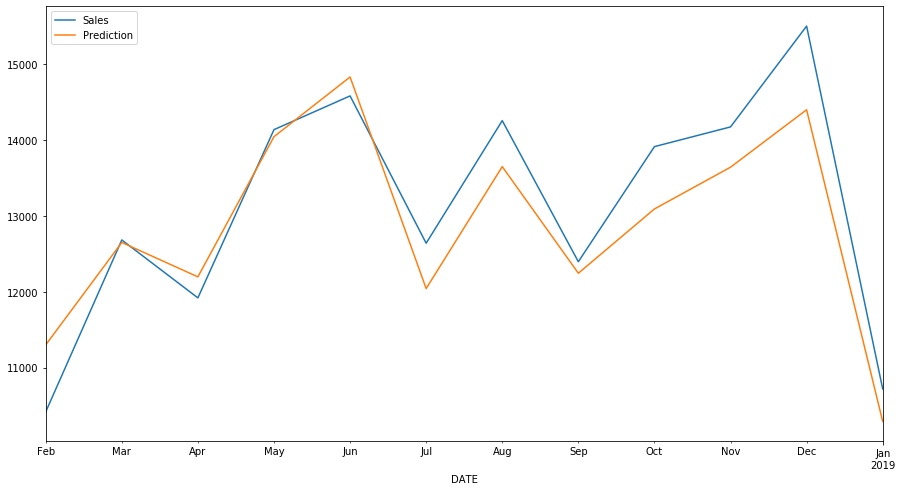

In [58]:
test.plot(figsize=(15,8))

In [59]:
model.save('la_sales.h5')